In [1]:
# 01 Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from datetime import datetime
import holidays

import lightgbm as lgb
import xgboost as xgb 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.simplefilter('ignore')

SEED = 86

In [2]:
df_2022 = pd.read_csv('../data/jepx/spot_summary_2022.csv', encoding='cp932')
df_2023 = pd.read_csv('../data/jepx/spot_summary_2023.csv', encoding='cp932')
df_2024 = pd.read_csv('../data/jepx/spot_summary_2024.csv', encoding='cp932')
df_2025 = pd.read_csv('../data/jepx/spot_summary_2025.csv', encoding='cp932')

In [3]:
dfs = [df_2022, df_2023, df_2024, df_2025]
df_all = pd.concat(dfs, ignore_index=True)
df_all['受渡日'] = pd.to_datetime(df_all['受渡日'])
df_all.head()

,受渡日,時刻コード,売り入札量(kWh),買い入札量(kWh),約定総量(kWh),システムプライス(円/kWh),エリアプライス北海道(円/kWh),エリアプライス東北(円/kWh),エリアプライス東京(円/kWh),エリアプライス中部(円/kWh),エリアプライス北陸(円/kWh),エリアプライス関西(円/kWh),エリアプライス中国(円/kWh),エリアプライス四国(円/kWh),エリアプライス九州(円/kWh),売りブロック入札総量(kWh),売りブロック約定総量(kWh),買いブロック入札総量(kWh),買いブロック約定総量(kWh)
0,2022-04-01,1,17007100,16995100,15959150,11.97,10.39,10.39,12.12,12.12,12.12,12.12,12.12,12.12,12.12,3454600,3260650,1329300,1036000
1,2022-04-01,2,17252550,17306150,15896600,14.47,14.47,14.47,14.47,14.47,14.47,14.47,14.47,14.47,14.47,3686600,3317300,1698000,1360900
2,2022-04-01,3,17496550,17531950,15988650,15.00,24.32,24.32,24.32,14.49,14.49,14.49,14.49,14.49,14.49,3867450,3318250,2071250,1662200
3,2022-04-01,4,17994700,17695250,16003200,16.55,16.55,16.55,16.55,16.55,16.55,16.55,16.55,16.55,16.55,4106800,3320550,2270650,1844100
4,2022-04-01,5,18144250,17845100,16073050,17.30,24.32,24.32,24.32,16.55,16.55,16.55,16.55,16.55,16.55,4297450,3321000,2246900,1773350


In [4]:
# 02 Feature Engineering

df_all['year'] = df_all['受渡日'].dt.year
# df_all['quarter'] = df_all['受渡日'].dt.quarter
df_all['month'] = df_all['受渡日'].dt.month
df_all['day_of_week'] = df_all['受渡日'].dt.day_of_week
# df_all['week_number'] = df_all['受渡日'].dt.isocalendar().week
df_all['day_of_year'] = df_all['受渡日'].dt.dayofyear

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]
for target in target_cols:
    df_all[f'{target}_lag336'] = df_all[target].shift(336)
    df_all[f'{target}_r336'] = df_all[target].rolling(336).mean()
    

# df_all['quarter_sin'] = np.sin(2*np.pi*(df_all['quarter']-1)/4)
# df_all['quarter_cos'] = np.cos(2*np.pi*(df_all['quarter']-1)/4)

df_all['month_sin'] = np.sin(2*np.pi*(df_all['month']-1)/12)
df_all['month_cos'] = np.cos(2*np.pi*(df_all['month']-1)/12)

df_all['dow_sin'] = np.sin(2*np.pi*df_all['day_of_week']/7)
df_all['dow_cos'] = np.cos(2*np.pi*df_all['day_of_week']/7)

df_all['days_in_year'] = np.where(df_all['受渡日'].dt.is_leap_year, 366, 365)
df_all['frac_of_year'] = (df_all['day_of_year'] - 1) / df_all['days_in_year']
df_all['doy_sin'] = np.sin(2 * np.pi * df_all['frac_of_year'])
df_all['doy_cos'] = np.cos(2 * np.pi * df_all['frac_of_year'])

df_all['tod_sin'] = np.sin(2*np.pi*df_all['時刻コード']/48)
df_all['tod_cos'] = np.cos(2*np.pi*df_all['時刻コード']/48)


df_all.head()
print(f'Nan 削除前: {df_all.isnull().sum().sum()}')
df_all = df_all.dropna()
print(f'Nan 削除後: {df_all.isnull().sum().sum()}')


Nan 削除前: 6039
Nan 削除後: 0


# LightGBM

In [267]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_val = df_val[select_column]
y_val = df_val[target]

X_test = df_test[select_column]
y_test = df_test[target]

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_iterations':100000,
    'learning_rate': 0.001,
    'num_leaves': 16,
    'max_depth': -1,
    'early_stopping_rounds': 1000,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-3,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'random_state': SEED,
    'verbosity': -1,
}

model = lgb.LGBMRegressor(**params)

model.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)],
    eval_metric = 'mae', 
    callbacks = [
        lgb.log_evaluation(1000)
    ]
)

Len train: 58416, Len val: 336, Len test: 336
Tail train: 58751   2025-08-06
Name: 受渡日, dtype: datetime64[ns], Len val: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
[1000]	valid_0's l1: 3.90049
[2000]	valid_0's l1: 3.5372
[3000]	valid_0's l1: 3.38666
[4000]	valid_0's l1: 3.38832
[5000]	valid_0's l1: 3.37812
[6000]	valid_0's l1: 3.37131
[7000]	valid_0's l1: 3.36314
[8000]	valid_0's l1: 3.34832
[9000]	valid_0's l1: 3.33463
[10000]	valid_0's l1: 3.32737
[11000]	valid_0's l1: 3.31129
[12000]	valid_0's l1: 3.30147
[13000]	valid_0's l1: 3.3177


,boosting_type,'gbdt'
,num_leaves,16
,max_depth,-1
,learning_rate,0.001
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [268]:
# 04 Test - 再学習していない

y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')


Test MAE: 1.7691
Test RMSE: 2.3330


In [269]:
# 05 Train-Test with all area
# Pre set

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_iterations':100000,
    'learning_rate': 0.001,
    'num_leaves': 16,
    'max_depth': -1,
    'early_stopping_rounds': 1000,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-3,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'random_state': SEED,
    'verbosity': -1,
}

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

df_mae_results = pd.DataFrame({'Region': target_cols})
df_rmse_results = pd.DataFrame({'Region': target_cols})
df_mae_results['LightGBM'] = 0
df_rmse_results['LightGBM'] = 0


# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    # 1 Select columns
    select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 
    'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    f'{target}_lag336', f'{target}_r336'
]
    
    X_train = df_train[select_column]
    y_train = df_train[target]

    X_val = df_val[select_column]
    y_val = df_val[target]

    X_test = df_test[select_column]
    y_test = df_test[target]

    model = lgb.LGBMRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set = [(X_val, y_val)],
        eval_metric = 'mae', 
        callbacks = [
            lgb.log_evaluation(1000)
        ]
    )

    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    
    df_mae_results.loc[df_mae_results["Region"] == target, "LightGBM"] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, "LightGBM"] = rmse


# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print('--------MAE--------')
print(df_mae_results)
print('--------RSME--------')
print(df_rmse_results)


Len train: 58416, Len val: 336, Len test: 336
Tail train: 58751   2025-08-06
Name: 受渡日, dtype: datetime64[ns], Len val: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
[1000]	valid_0's l1: 3.28511
[2000]	valid_0's l1: 3.14113
[3000]	valid_0's l1: 3.17772
予測地域: エリアプライス東北(円/kWh)
[1000]	valid_0's l1: 3.35837
[2000]	valid_0's l1: 3.20679
[3000]	valid_0's l1: 3.18644
予測地域: エリアプライス東京(円/kWh)
[1000]	valid_0's l1: 3.90049
[2000]	valid_0's l1: 3.5372
[3000]	valid_0's l1: 3.38666
[4000]	valid_0's l1: 3.38832
[5000]	valid_0's l1: 3.37812
[6000]	valid_0's l1: 3.37131
[7000]	valid_0's l1: 3.36314
[8000]	valid_0's l1: 3.34832
[9000]	valid_0's l1: 3.33463
[10000]	valid_0's l1: 3.32737
[11000]	valid_0's l1: 3.31129
[12000]	valid_0's l1: 3.30147
[13000]	valid_0's l1: 3.3177
予測地域: エリアプライス中部(円/kWh)
[1000]	valid_0's l1: 3.32661
[2000]	valid_0's l1: 3.2475
予測地域: エリアプライス北陸(円/kW

In [270]:
# 06 Save Hyperparams

outdir = Path('artifacts')
outdir.mkdir(exist_ok=True)

# Save
df_params = pd.DataFrame([params])
df_params_t = df_params.T
df_params_t.columns = ['LightGBM Hyper Params']
df_params_t = df_params_t.astype({'LightGBM Hyper Params': 'string'})   

display(df_params_t)
df_params_t.to_parquet(outdir / 'LightGBM_params.parquet', index=True)

,LightGBM Hyper Params
objective,regression
metric,mae
num_iterations,100000
learning_rate,0.001
num_leaves,16
max_depth,-1
early_stopping_rounds,1000
min_data_in_leaf,20
min_sum_hessian_in_leaf,0.001
bagging_fraction,0.9


# XGBoost

In [271]:
# 03 Training
target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_val = df_val[select_column]
y_val = df_val[target]

X_test = df_test[select_column]
y_test = df_test[target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'reg:absoluteerror',
    'silent': 1,
    'booster': 'gbtree',
    'eta': 0.1,
    'gamma': 0.0,
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': 1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED
}
num_round = 100000

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=1000, verbose_eval=1000)

Len train: 58416, Len val: 336, Len test: 336
Tail train: 58751   2025-08-06
Name: 受渡日, dtype: datetime64[ns], Len val: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
[0]	train-mae:5.20167	eval-mae:3.09643
[1000]	train-mae:1.36652	eval-mae:3.89402
[1017]	train-mae:1.36011	eval-mae:3.88624


In [272]:
# 04 Test - 再学習していない

y_pred = model.predict(dtest)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Test MAE: 1.4069
Test RMSE: 1.8099


In [273]:
# 05 Train-Test with all area
# Pre set

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

params = {
    'objective': 'reg:absoluteerror',
    'silent': 1,
    'booster': 'gbtree',
    'eta': 0.1,
    'gamma': 0.0,
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': 1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED
}

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

df_mae_results['XGBoost'] = 0
df_rmse_results['XGBoost'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    # 1 Select columns
    select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 
    'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    f'{target}_lag336', f'{target}_r336'
]
    
    X_train = df_train[select_column]
    y_train = df_train[target]

    X_val = df_val[select_column]
    y_val = df_val[target]

    X_test = df_test[select_column]
    y_test = df_test[target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    num_round = 100000

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=1000, verbose_eval=1000)
    
    y_pred = model.predict(dtest)

    mae  = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, "XGBoost"] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, "XGBoost"] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print('--------MAE--------')
print(df_mae_results)
print('--------RSME--------')
print(df_rmse_results)


Len train: 58416, Len val: 336, Len test: 336
Tail train: 58751   2025-08-06
Name: 受渡日, dtype: datetime64[ns], Len val: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
[0]	train-mae:5.49838	eval-mae:3.02307
[1000]	train-mae:1.62231	eval-mae:3.83108
[1017]	train-mae:1.61597	eval-mae:3.82266
予測地域: エリアプライス東北(円/kWh)
[0]	train-mae:5.44387	eval-mae:2.76173
[1000]	train-mae:1.57095	eval-mae:4.04969
[1007]	train-mae:1.56809	eval-mae:4.04861
予測地域: エリアプライス東京(円/kWh)
[0]	train-mae:5.20167	eval-mae:3.09643
[1000]	train-mae:1.36652	eval-mae:3.89402
[1017]	train-mae:1.36011	eval-mae:3.88624
予測地域: エリアプライス中部(円/kWh)
[0]	train-mae:5.10229	eval-mae:2.80243
[1000]	train-mae:1.52835	eval-mae:2.80933
[1379]	train-mae:1.42267	eval-mae:2.75241
予測地域: エリアプライス北陸(円/kWh)
[0]	train-mae:5.18201	eval-mae:3.16790
[1000]	train-mae:1.47265	eval-mae:3.34659
[1191]	train-mae:1.40956	eval-mae:

# Linear Regression

In [274]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

model = LinearRegression().fit(X_train, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [275]:
# 04 Test - 再学習していない

r2_score = model.score(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.5644080275188794, Coefficients: [-0.1997035   2.57603895  3.85653532  1.15983212 -0.35028302 -3.53859218
 -3.35604812 -2.17360597  0.62020585  0.29857841  0.64135461], Intercept: 405.00887292610975
Test MAE: 2.1304
Test RMSE: 2.7090


In [276]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

df_mae_results['Linear Regression'] = 0
df_rmse_results['Linear Regression'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = LinearRegression().fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Linear Regression'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Linear Regression'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226
6   エリアプライス中国(円/kWh)  2.516918  1.452028           2.094666
7   エリアプライス四国(円/kWh)  2.151759  1.926346           1.997347
8   エリアプライス九州(円/kWh)  2.818667  1.602318           

# Lasso Regression

In [277]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = linear_model.Lasso(alpha=0.1).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [278]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.5608677869623373, Coefficients: [-0.15544891 -0.         -0.          0.71694749 -0.14973378 -0.05272689
 -0.09011999 -1.43658644  0.33844137  2.83630556  4.18040319], Intercept: 15.964190325435736
Test MAE: 2.0682
Test RMSE: 2.6596


In [279]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['Lasso Regression'] = 0
df_rmse_results['Lasso Regression'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = linear_model.Lasso(alpha=0.1).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Lasso Regression'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Lasso Regression'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002
6   エリアプライス中国(円/kWh)  2.516918  1.452028     

# Ridge Regression

In [280]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = linear_model.Ridge(alpha=1.0).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [281]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.5644080211490616, Coefficients: [-0.20498789  1.80448182  2.7248123   0.82031868 -0.24762399 -2.46125662
 -2.38783255 -1.53695123  0.43854606  2.83495044  4.24904701], Intercept: 15.964190325435736
Test MAE: 2.1304
Test RMSE: 2.7090


In [282]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['Ridge Regression'] = 0
df_rmse_results['Ridge Regression'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = linear_model.Ridge(alpha=0.1).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Ridge Regression'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Ridge Regression'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# Elastic Net

In [283]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [284]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.560424109505965, Coefficients: [-0.35014222 -0.         -0.          0.73068271 -0.19032927 -0.16127671
 -0.13677285 -1.41655897  0.37019243  2.83248899  3.87345039], Intercept: 15.964190325435741
Test MAE: 2.0642
Test RMSE: 2.6714


In [285]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['Elastic Net'] = 0
df_rmse_results['Elastic Net'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Elastic Net'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Elastic Net'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# SVR

In [286]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)  

model = SVR(
    kernel="rbf",
    degree=3,
    gamma="scale",
    coef0=0.0,
    tol=1e-3,
    C=1.0,
    epsilon=0.2,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1
).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [287]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.7336368386180023, Coefficients: [-0.35014222 -0.         -0.          0.73068271 -0.19032927 -0.16127671
 -0.13677285 -1.41655897  0.37019243  2.83248899  3.87345039], Intercept: [24.19210831]
Test MAE: 1.9245
Test RMSE: 2.4360


In [288]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['SVR'] = 0
df_rmse_results['SVR'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = SVR(
    kernel="rbf",
    degree=3,
    gamma="scale",
    coef0=0.0,
    tol=1e-3,
    C=1.0,
    epsilon=0.2,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1
    ).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'SVR'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'SVR'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# KNN

In [289]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)  

model = KNeighborsRegressor(
    n_neighbors=50,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1
).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [290]:
# 04 Test - 再学習していない

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Test MAE: 2.4890
Test RMSE: 3.1136


In [291]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['KNN'] = 0
df_rmse_results['KNN'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = KNeighborsRegressor(
    n_neighbors=50,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1
    ).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'KNN'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'KNN'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# LSTM

In [5]:
target = 'エリアプライス東京(円/kWh)'

data_X = []
data_y = []

# 時数 (どこまで過去のデータを考慮するか)
p = 336

for i in range(len(df_all)-p):
    data_X.append(df_all[target][i:i+p]) # Type: List
    data_y.append(df_all[target][i+p]) # Type: List

data_X = np.array(data_X) # Type: np.array
data_y = np.array(data_y) # Type: np.array

In [6]:
# Split train and test data
len_train = int(len(data_X)*0.7)

X_train = data_X[:len_train]
X_test = data_X[len_train:]
y_train = data_y[:len_train]
y_test = data_y[len_train:]

print(f'X_train: {len(X_train)}, X_test: {len(X_test)}')

X_train: 41126, X_test: 17626


In [7]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train_n = scaler_x.fit_transform(X_train)
X_test_n = scaler_x.transform(X_test)
scaler_y = MinMaxScaler()
y_train_n = scaler_y.fit_transform(y_train.reshape(len(y_train),1))
y_test_n = scaler_y.transform(y_test.reshape(len(y_test),1))

In [8]:
# データの確認  - (データの数, 説明変数の数(p))になっている。
print(X_train_n.shape, X_test_n.shape)

(41126, 336) (17626, 336)


In [9]:
# データの形を変更  - （データの数, 系列数, 説明変数の数(p)）に変更する。
X_train_n = np.reshape(X_train_n, (X_train_n.shape[0], 1, X_train_n.shape[1]))
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], 1, X_test_n.shape[1]))

In [10]:
# モデルの実装
from keras.layers import LSTM, Dense
from keras import models

# 時数 (どこまで過去のデータを考慮するか)
p = 336

# モデルの実装
model = models.Sequential()
model.add(
    LSTM(
        100,
        activation='tanh',
        input_shape=(1, p)
    )
)
model.add(Dense(1, activation='linear'))

# 学習設定
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)


In [11]:
# モデルの学習
result = model.fit(
    X_train_n,
    y_train_n,
    batch_size=10,
    epochs=100
)

Epoch 1/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.8679e-04
Epoch 2/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.2777e-04
Epoch 3/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 6.9926e-05
Epoch 4/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.9609e-05
Epoch 5/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4.0832e-05
Epoch 6/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.0492e-05
Epoch 7/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.1073e-05
Epoch 8/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2.2635e-05
Epoch 9/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.2240e-05
Epoch 10/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.7950e-05
Epoch 11/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.0184e-05
Epoch 12/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.5650e-05
Epoch 13/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.3865e-05
Epoch 14/100
4113/4113 ━━━━━━━━━━━

In [12]:
# 予測値の算出
y_pred_n = model.predict(X_test_n)

#正規化の復元
y_pred = scaler_y.inverse_transform(y_pred_n).flatten()


mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test MAE: 0.0682
Test RMSE: 0.0855


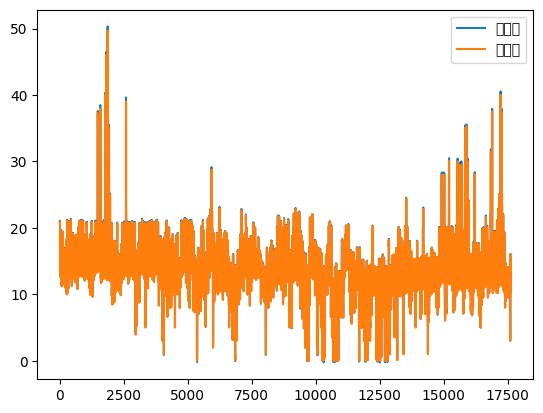

In [13]:
plt.plot(y_pred, label='予測値')
plt.plot(y_test, label='実測値')
plt.legend()

# LSTM2

In [17]:
target = 'エリアプライス東京(円/kWh)'

data_X = []
data_y = []

# 時数 (どこまで過去のデータを考慮するか)
p = 336

for i in range(len(df_all)-p):
    data_X.append(df_all[target][i:i+p]) # Type: List
    data_y.append(df_all[target][i+p]) # Type: List

data_X = np.array(data_X) # Type: np.array
data_y = np.array(data_y) # Type: np.array

In [20]:
# Split train, val and test data
X_train = data_X[:-48*7] # 最後の336行を除外
X_test = data_X[-48*7:] # 最後の336行を取得

X_val = X_train[-48*7:] # 最後の336行を取得
X_train = X_train[:-48*7] # 最後の336行を除外

y_train = data_y[:-48*7] # 最後の336行を除外
y_test = data_y[-48*7:] # 最後の336行を取得

y_val = y_train[-48*7:] # 最後の336行を取得
y_train = y_train[:-48*7] # 最後の336行を除外

print(f'X_train: {len(X_train)}, X_val: {len(X_val)} X_test: {len(X_test)}')

# print(f"Tail train: {X_train.tail(1)['受渡日']}, Len test: {X_test.tail(1)['受渡日']}")
# print(f'X_train[-1].sum(): {X_train[-1].sum()}')
# print(f'X_val[-1].sum(): {X_val[-1].sum()}')
# print(f'X_test[-1].sum(): {X_test[-1].sum()}')
# print('-----------------------------------------')

X_train: 58080, X_val: 336 X_test: 336


In [21]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train_n = scaler_x.fit_transform(X_train)
X_val_n = scaler_x.transform(X_val)
X_test_n = scaler_x.transform(X_test)
scaler_y = MinMaxScaler()
y_train_n = scaler_y.fit_transform(y_train.reshape(len(y_train),1))
y_val_n = scaler_y.transform(y_val.reshape(len(y_val),1))
y_test_n = scaler_y.transform(y_test.reshape(len(y_test),1))

In [22]:
# データの確認  - (データの数, 説明変数の数(p))になっている。
print(X_train_n.shape, X_val_n.shape, X_test_n.shape)

(58080, 336) (336, 336) (336, 336)


In [23]:
# データの形を変更  - （データの数, 系列数, 説明変数の数(p)）に変更する。
X_train_n = np.reshape(X_train_n, (X_train_n.shape[0], 1, X_train_n.shape[1]))
X_val_n = np.reshape(X_val_n, (X_val_n.shape[0], 1, X_val_n.shape[1]))
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], 1, X_test_n.shape[1]))

In [24]:
# モデルの実装
from keras.layers import LSTM, Dense
from keras import models


# 時数 (どこまで過去のデータを考慮するか)
p = 336

# モデルの実装
model = models.Sequential()
model.add(
    LSTM(
        100,
        activation='tanh',
        input_shape=(1, p)
    )
)
model.add(Dense(1, activation='linear'))

# 学習設定
model.compile(
    loss='mae',
    optimizer='adam'
)


In [25]:
# モデルの実装
from keras.layers import LSTM, Dense
from keras import models
from tensorflow.keras.optimizers import Adam


# 時数 (どこまで過去のデータを考慮するか)
p = 336

# モデルの実装
model = models.Sequential()
model.add(
    LSTM(
        100,
        activation='tanh',
        input_shape=(1, p)
    )
)
model.add(Dense(1, activation='linear'))

# 学習設定
model.compile(
    loss='mae',
    optimizer=Adam(learning_rate=1e-3)
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',      # 検証損失を監視
    patience=8,              # 8エポック連続で改善しなければ停止
    restore_best_weights=True,
    min_delta=0.0,           # これ以上の改善がなければ「停滞」とみなす
    verbose=1
)

result = model.fit(
    X_train_n, y_train_n,
    validation_data=(X_val_n, y_val_n),
    batch_size=10,
    epochs=100,
    shuffle=False,
    callbacks=[es]
)

Epoch 1/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0131 - val_loss: 0.0085
Epoch 2/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 3/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0081 - val_loss: 0.0104
Epoch 4/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 5/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0084 - val_loss: 0.0106
Epoch 6/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 7/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 8/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 9/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 10/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 11/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 12/1

In [28]:
# 予測値の算出
y_pred_n = model.predict(X_test_n)

#正規化の復元
y_pred = scaler_y.inverse_transform(y_pred_n).flatten()


mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test MAE: 1.2308
Test RMSE: 1.5664


In [ ]:
target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_val = df_val[select_column]
y_val = df_val[target]

X_test = df_test[select_column]
y_test = df_test[target]

# Save MAE & RSME 

In [292]:
from pathlib import Path

outdir = Path("artifacts")
outdir.mkdir(exist_ok=True)

# Save
df_mae_results.to_parquet(outdir / "df_mae_results.parquet", index=False)
df_rmse_results.to_parquet(outdir / "df_rmse_results.parquet", index=False)


In [293]:
df_mae_results

,Region,LightGBM,XGBoost,Linear Regression,Lasso Regression,Ridge Regression,Elastic Net,SVR,KNN
0,エリアプライス北海道(円/kWh),3.092928,2.796934,3.446297,3.324270,3.446296,3.322515,3.335704,3.319845
1,エリアプライス東北(円/kWh),1.913817,1.368339,2.165518,2.071845,2.165513,2.072985,2.684432,2.417305
2,エリアプライス東京(円/kWh),1.769082,1.406918,2.130391,2.068184,2.130390,2.064247,1.924538,2.488993
3,エリアプライス中部(円/kWh),2.565842,1.475554,2.264183,2.227561,2.264186,2.236624,2.171275,2.901029
4,エリアプライス北陸(円/kWh),2.871607,1.356805,2.350655,2.356141,2.350660,2.378747,2.411155,3.221498
5,エリアプライス関西(円/kWh),2.885098,1.370141,2.347226,2.353002,2.347232,2.370843,2.531731,3.220873
6,エリアプライス中国(円/kWh),2.516918,1.452028,2.094666,2.102660,2.094672,2.102257,1.898994,2.610990
7,エリアプライス四国(円/kWh),2.151759,1.926346,1.997347,1.950255,1.997352,1.963685,1.777900,2.590504
8,エリアプライス九州(円/kWh),2.818667,1.602318,2.233973,2.188130,2.233974,2.165925,1.405259,2.481850


In [294]:
df_rmse_results

,Region,LightGBM,XGBoost,Linear Regression,Lasso Regression,Ridge Regression,Elastic Net,SVR,KNN
0,エリアプライス北海道(円/kWh),5.473329,4.554469,6.038479,5.995096,6.038480,5.993498,4.956513,4.914933
1,エリアプライス東北(円/kWh),2.593934,1.794924,2.864766,2.771974,2.864760,2.772367,3.116584,2.920205
2,エリアプライス東京(円/kWh),2.332957,1.809948,2.708982,2.659566,2.708981,2.671404,2.435983,3.113558
3,エリアプライス中部(円/kWh),3.280572,1.890655,2.935454,2.917217,2.935457,2.920040,2.897715,3.913168
4,エリアプライス北陸(円/kWh),3.562512,1.833385,3.122539,3.143603,3.122547,3.145507,3.155033,4.280628
5,エリアプライス関西(円/kWh),3.563258,1.872600,3.136841,3.158411,3.136849,3.155510,3.241526,4.279430
6,エリアプライス中国(円/kWh),3.043924,1.822663,2.772199,2.763377,2.772208,2.778338,2.342050,3.441352
7,エリアプライス四国(円/kWh),2.866855,2.733425,2.665476,2.648914,2.665479,2.657903,2.515585,3.339586
8,エリアプライス九州(円/kWh),3.279979,1.950128,2.828204,2.774602,2.828206,2.768313,1.804539,3.257024


In [295]:
STOP

NameError: name 'STOP' is not defined

MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset


In [ ]:
# 03 Training
target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'quarter', 'month', '時刻コード', 'day_of_week', 'week_number', 'day_of_year'
]

df_train = df_all[:-48*7]
df_val = df_train[-48*7:]
df_test = df_all[-48*7:]

X_train = df_train[select_column]
y_train = df_train[target]

X_val = df_val[select_column]
y_val = df_val[target]

X_test = df_test[select_column]
y_test = df_test[target]


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

torch.manual_seed(SEED)
num_batches = 100

In [ ]:
# Make Dataset
class TrainDataset(Dataset):
    def __init__(self, df_train):
        self.X = df_train[select_column].values
        self.y = df_train[target].values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
    
train_dataset = TrainDataset(df_train)

In [ ]:
# Define Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
         nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
# ===== 0. Imports =====
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===== 1. Config =====
SEED = 42
target = 'エリアプライス東京(円/kWh)'
select_column = ['year','quarter','month','時刻コード','day_of_week','week_number','day_of_year']

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)

# ===== 2. Split (train / val / test を完全分離) =====
# 直近7日=テスト、その直前7日=バリデーション、それ以前=学習
df_train = df_all[:-48*14].copy()
df_val   = df_all[-48*14:-48*7].copy()
df_test  = df_all[-48*7:].copy()

X_train = df_train[select_column].to_numpy()
y_train = df_train[target].to_numpy()

X_val = df_val[select_column].to_numpy()
y_val = df_val[target].to_numpy()

X_test = df_test[select_column].to_numpy()
y_test = df_test[target].to_numpy()

# ===== 3. Scale features (学習でfit→val/testにtransform) =====
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# ===== 4. Tensor & DataLoader =====
batch_size = 64

train_ds = TensorDataset(
    torch.tensor(X_train_s, dtype=torch.float32),
    torch.tensor(y_train,   dtype=torch.float32).view(-1,1)
)
val_ds = TensorDataset(
    torch.tensor(X_val_s, dtype=torch.float32),
    torch.tensor(y_val,   dtype=torch.float32).view(-1,1)
)
test_ds = TensorDataset(
    torch.tensor(X_test_s, dtype=torch.float32),
    torch.tensor(y_test,   dtype=torch.float32).view(-1,1)
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# ===== 5. 2-layer MLP (1 hidden) with ReLU =====
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),                # ← ReLU
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP2(input_dim=X_train_s.shape[1], hidden=64).to(device)

# ===== 6. Loss & Optimizer =====
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ===== 7. Train loop =====
num_epochs = 50
for epoch in range(1, num_epochs+1):
    # train
    model.train()
    tr_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(train_loader.dataset)

    # validate
    model.eval()
    va_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            va_loss += loss.item() * xb.size(0)
    va_loss /= len(val_loader.dataset)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Train MSE: {tr_loss:.4f} | Val MSE: {va_loss:.4f}")

# ===== 8. Test 評価（MAE / RMSE）=====
model.eval()
preds = []
ys = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy().ravel()
        preds.append(pred)
        ys.append(yb.numpy().ravel())

y_pred = np.concatenate(preds)
y_true = np.concatenate(ys)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test MAE : {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")


Epoch   1 | Train MSE: 255.9683 | Val MSE: 14.5854
Epoch  10 | Train MSE: 116.0628 | Val MSE: 9.9382
Epoch  20 | Train MSE: 101.0773 | Val MSE: 9.5714
Epoch  30 | Train MSE: 92.9354 | Val MSE: 11.4712
Epoch  40 | Train MSE: 90.2963 | Val MSE: 11.5367
Epoch  50 | Train MSE: 88.3826 | Val MSE: 12.5955
Test MAE : 3.0517
Test RMSE: 4.0195


In [ ]:
# KERAS
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import ReLU, PReLU
from keras.layers.core import Dense, Dropout
from keras.layers.normarization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler



ModuleNotFoundError: No module named 'keras.layers.advanced_activations'

In [ ]:
base_param = {
    'input_dropout': 0.0,
    'hidden_layers': 3,
    'hidden_units': 96,
    'hidden_actovation': 'relu',
    'hidden_dropout': 0.2,
    'bagtch_norm': 'before_act',
    'optimizer': {'type': 'adam', 'lr': 0.001},
    'batch_size': 64,
}


In [ ]:
class MLP:
    def __init__(self, params):
        self.params = params
        self.scaler = None
        self.model = None
    
    def fit(self, X_train, y_train, X_val, y_val):
        # params
        input_dropout = self.params['input_dropout']
        hidden_layers = int(self.params['hidden_layers'])
        hidden_units = int(self.params['hidden_units'])
        hidden_activation = self.params['hidden_actovation']
        hidden_dropout = self.params['hidden_dropout']
        batch_norm = self.params['bagtch_norm']
        optimizer_type = self.params['optimizer']['type']
        optimizer_lr = self.params['optimizer']['lr']
        batch_size = int(self.params['batch_size'])
        
        # Scaler
        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val = self.scaler.transform(X_val)
        
        self.model = Sequential()
        
        # 入力層
        self.model.add(Dropout(input_dropout, input_shape(X_train.shape[1],)))
        
        # 中間層
        for i in range(hidden_layers):
            self.model.add(Dense(hidden_units))
            if batch_norm == 'before_act':
                self.model.add(BatchNormalization())
            if hidden_activation == 'prelu':
                self.model.add(PReLU())
            elif hidden_activation == 'relu':
                self.model.add(ReLU())
            else:
                raise NotImplementedError
            self.model.add(Dropout(hidden_dropout))
            
        # 出力層
        self.model.add(Dense())
    
        

In [ ]:
df_train = df_all[:-48*7]
df_val = df_train[-48*7:]
df_test = df_all[-48*7:]

X_train = df_train[select_column]
y_train = df_train[target]

X_val = df_val[select_column]
y_val = df_val[target]

X_test = df_test[select_column]
y_test = df_test[target]


In [ ]:
import numpy as np
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, PReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

class MLP:
    def __init__(self, params):
        self.params = params
        self.scaler = None
        self.model = None
        self.H = 336  # 7 days * 48 half-hour steps

    def _make_optimizer(self, optimizer_type, lr):
        if optimizer_type.lower() == 'adam':
            return Adam(learning_rate=lr)
        elif optimizer_type.lower() == 'sgd':
            return SGD(learning_rate=lr, momentum=0.9, nesterov=True)
        else:
            raise ValueError(f'Unknown optimizer: {optimizer_type}')

    def fit(self, X_train, y_train, X_val, y_val):
        # params (typo修正済み)
        input_dropout    = float(self.params.get('input_dropout', 0.0))
        hidden_layers    = int(self.params.get('hidden_layers', 2))
        hidden_units     = int(self.params.get('hidden_units', 256))
        hidden_activation= self.params.get('hidden_activation', 'relu')  # ← 'hidden_actovation'を修正
        hidden_dropout   = float(self.params.get('hidden_dropout', 0.1))
        batch_norm       = self.params.get('batch_norm', 'none')         # ← 'bagtch_norm'を修正
        optimizer_type   = self.params['optimizer']['type']
        optimizer_lr     = float(self.params['optimizer']['lr'])
        batch_size       = int(self.params.get('batch_size', 256))
        epochs           = int(self.params.get('epochs', 200))
        use_huber        = bool(self.params.get('use_huber', False))

        # スケーリング（リーク防止）
        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)

        # モデル
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],)))
        if input_dropout > 0:
            model.add(Dropout(input_dropout))

        for _ in range(hidden_layers):
            model.add(Dense(hidden_units))
            if batch_norm == 'before_act':
                model.add(BatchNormalization())
            if hidden_activation == 'prelu':
                model.add(PReLU()
            )
            elif hidden_activation == 'relu':
                model.add(ReLU())
            else:
                raise NotImplementedError(f'activation {hidden_activation}')
            if hidden_dropout > 0:
                model.add(Dropout(hidden_dropout))

        # ★ 出力層：ホライズン分の多出力・線形回帰
        model.add(Dense(self.H, activation='linear', name='y_hat'))

        # 最適化 & 損失
        optimizer = self._make_optimizer(optimizer_type, optimizer_lr)
        loss_fn = Huber(delta=1.0) if use_huber else MeanSquaredError()
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=[])

        # 早期終了
        es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[es],
            verbose=1
        )
        self.model = model

    def predict(self, X):
        X = self.scaler.transform(X)
        return self.model.predict(X)
